In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

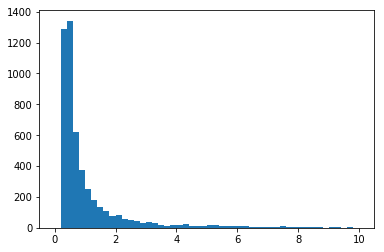

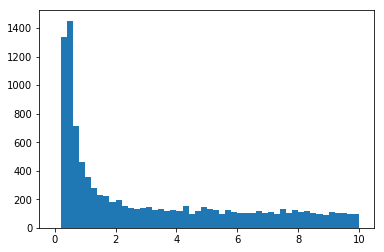

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

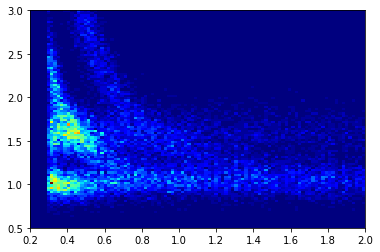

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.002345,0.992644,1.075651,1.132047,1.258851,1.134535,4.338509,0,47
1,0.002044,1.061244,1.442640,1.356841,1.634750,1.152541,9.842911,0,63
2,0.001662,0.964156,1.067225,1.594481,1.139802,1.292813,5.791195,0,63
3,0.001981,0.923988,1.103137,1.132441,1.187712,1.248733,1.408798,0,55
4,0.001908,0.911512,1.171345,1.123244,1.195306,1.345555,4.648356,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.002345,0.992644,1.075651,1.132047,1.258851,1.134535,4.338509,0,47,0.002345,...,1.075651,1.132047,1.0,1.132047,1.487883,0.0,0.000000,1.134535,1.0,1.134535
1,0.002044,1.061244,1.442640,1.356841,1.634750,1.152541,9.842911,0,63,0.002044,...,1.442640,1.356841,1.0,1.356841,1.634750,1.0,1.634750,1.152541,1.0,1.152541
2,0.001662,0.964156,1.067225,1.594481,1.139802,1.292813,5.791195,0,63,0.001662,...,1.067225,1.594481,1.0,1.594481,1.139802,1.0,1.139802,1.292813,1.0,1.292813
3,0.001981,0.923988,1.103137,1.132441,1.187712,1.248733,1.408798,0,55,0.001981,...,1.103137,1.485870,0.0,0.000000,1.187712,1.0,1.187712,1.248733,1.0,1.248733
4,0.001908,0.911512,1.171345,1.123244,1.195306,1.345555,4.648356,0,63,0.001908,...,1.171345,1.123244,1.0,1.123244,1.195306,1.0,1.195306,1.345555,1.0,1.345555
5,0.002357,1.116974,1.417574,1.129733,1.231569,1.672636,9.834721,0,63,0.002357,...,1.417574,1.129733,1.0,1.129733,1.231569,1.0,1.231569,1.672636,1.0,1.672636
6,0.002000,1.075881,1.055386,1.016474,1.045164,0.894279,1.656978,0,63,0.002000,...,1.055386,1.016474,1.0,1.016474,1.045164,1.0,1.045164,0.894279,1.0,0.894279
7,0.001980,1.022756,1.272769,1.308062,1.414784,1.097513,8.872737,0,63,0.001980,...,1.272769,1.308062,1.0,1.308062,1.414784,1.0,1.414784,1.097513,1.0,1.097513
8,0.001835,1.086536,1.120982,1.065699,1.054940,1.151702,2.846979,0,55,0.001835,...,1.120982,1.485870,0.0,0.000000,1.054940,1.0,1.054940,1.151702,1.0,1.151702
9,0.002543,0.917652,1.565581,1.463130,1.392928,1.384138,7.920522,0,59,0.002543,...,0.000000,1.463130,1.0,1.463130,1.392928,1.0,1.392928,1.384138,1.0,1.384138


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [13]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))
lam = 1e-4

def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    W = K.variable(value=modelpt.get_layer('encoded').get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    h = modelpt.get_layer('encoded').output
    dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive

inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
enc1   = Dense(units=64, activation='selu')(inputs)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='selu', name='encoded')(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss=contractive_loss,
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [14]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
encoded (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                192       
__________

# perfect tracks

In [15]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 355us/step - loss: 0.0682 - mean_squared_error: 0.0680 - val_loss: 0.0376 - val_mean_squared_error: 0.0375
Epoch 2/5
20000/20000 [==============================] - 5s 275us/step - loss: 0.0392 - mean_squared_error: 0.0390 - val_loss: 0.0382 - val_mean_squared_error: 0.0380
Epoch 3/5
20000/20000 [==============================] - 6s 277us/step - loss: 0.0353 - mean_squared_error: 0.0351 - val_loss: 0.0372 - val_mean_squared_error: 0.0370
Epoch 4/5
20000/20000 [==============================] - 6s 280us/step - loss: 0.0364 - mean_squared_error: 0.0363 - val_loss: 0.0345 - val_mean_squared_error: 0.0344
Epoch 5/5
20000/20000 [==============================] - 5s 275us/step - loss: 0.0343 - mean_squared_error: 0.0342 - val_loss: 0.0401 - val_mean_squared_error: 0.0401


In [17]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,26275,0.005455,0.450244,2.566274,2.579727,3.291105,3.678182,0.449221,3,47,...,0.000000,3.678182,1.0,3.678182,0.005044,0.471757,2.917360,2.841505,2.850626,2.786802
1,18728,0.002551,0.918248,1.489984,1.556601,1.521115,1.489452,0.327849,2,63,...,1.521115,1.489452,1.0,1.489452,0.002570,0.940787,1.470252,1.513014,1.497566,1.497624
2,20262,0.001855,1.036015,0.986494,1.231528,1.117397,1.190801,7.751631,3,62,...,1.117397,1.190801,1.0,1.190801,0.001797,1.069504,1.034825,1.093437,1.092278,1.103765


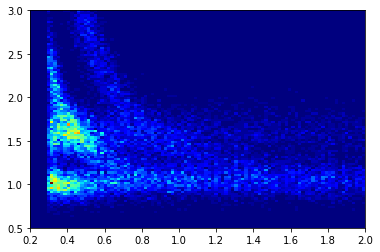

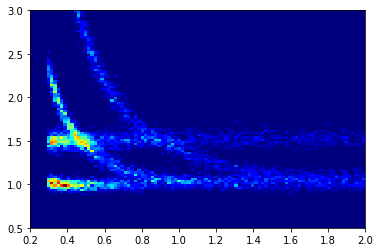

In [18]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Train with zeros

In [ ]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

In [ ]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

In [ ]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


In [ ]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

In [ ]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [ ]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

In [ ]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

In [ ]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [ ]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [ ]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

In [ ]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

In [ ]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [ ]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [ ]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [ ]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

In [ ]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()